## Import parqet files

In [1]:
from numpy.random import RandomState
from pandas.core.common import random_state

from project_1.loading import *
# Load data from parquet file
import pandas as pd
import numpy as np
from project_1.config import PROJ_ROOT, PROCESSED_DATA_DIR

df_a, df_b, df_c = load_before_scaling()
death_a, death_b, death_c = load_outcomes()

print(df_a.columns)

2025-03-31 11:11:40.071 | INFO     | project_1.config:<module>:11 - PROJ_ROOT path is: /Users/francescobondi/Desktop/stuff/ETH/FS25/ML for Healthcare/project-1-ml4hc


Shapes of the datasets:
Set A: (183416, 43) Set B: (183495, 43) Set C: (183711, 43)
Shapes of labels:
Set A: (4000, 2) Set B: (4000, 2) Set C: (4000, 2)
Index(['Time', 'RecordID', 'Age', 'BUN', 'Creatinine', 'GCS', 'Gender',
       'Glucose', 'HCO3', 'HCT', 'HR', 'Height', 'ICUType', 'K', 'Mg',
       'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'Platelets', 'RespRate', 'Temp',
       'TroponinT', 'Urine', 'WBC', 'Weight', 'ALP', 'ALT', 'AST', 'Albumin',
       'Bilirubin', 'FiO2', 'MechVent', 'PaCO2', 'PaO2', 'pH', 'DiasABP',
       'MAP', 'SaO2', 'SysABP', 'Lactate', 'Cholesterol', 'TroponinI'],
      dtype='object')


### Setting environment variables

In [2]:
run_efficient = False
#llm_model = 'deepseek-r1:1.5b'
llm_model = 'llama3.2:3b'
device_map = "cpu" # or "cuda"

### Checkout environment and assure that everything runs smoothly

In [4]:
# Ollama test

from ollama import chat
from ollama import ChatResponse

response: ChatResponse = chat(model=llm_model, messages=[
    {
    'role': 'system',
    'content': 'You are a helpful assistant who explains things clearly and concisely. Your answes are always very short, maximum 100 letters.',
  },
  {
    'role': 'user',
    'content': 'Why is the sky blue?',
  },
])
print(response['message']['content'])


# Embedding test
from ollama import embed

response = embed(model=llm_model, input= 'You are a helpful assistant who explains things clearly and concisely. Your answes are always very short, maximum 100 letters.')
np.array(response.get("embeddings", []), dtype=float)

The Earth's atmosphere scatters sunlight in all directions. Short (blue) wavelengths scatter more than long (red) wavelengths, giving the sky its blue color.


array([[ 0.01557815,  0.01416435, -0.01622   , ..., -0.01586473,
         0.00051227, -0.00383137]])

In [5]:
# If not installed yet:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map=device_map,
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
embeddings, tokenizer_state = pipeline.embed(context)

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /private/var/folders/vm/dlvhdp0n0jg_tp24ng5z84080000gn/T/pip-req-build-nhyq8_fe
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /private/var/folders/vm/dlvhdp0n0jg_tp24ng5z84080000gn/T/pip-req-build-nhyq8_fe
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 94e20ea7e510ac4d665492b8bed8836a5143f16e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.5.0-py3-none-any.whl size=29408 sha256=b17f84325bd5ed0f4757227997214e2c0d3b4452ab26432d87109511a2d61873
  Stored in directory: /private/var/folders/vm/dlvhdp0n0jg_tp24ng5z84080000gn/T/pip-ephem-wheel-cache-25_1at3_/wheels/b9/a6/b5/75fca7306751a3bc92a63680f861f44a42a8776f6423cf0188
Successfully built chronos-forecasting


/Users/francescobondi/anaconda3/envs/TUM/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Q4.1 Prompting an LLM to solve a time-series problem

## Patient Summary short
only includes the most important data, without much noise

In [6]:
def generate_summary_statistical(patient_df):
    features = {}
    # Assuming df is already filtered for a single patient
    features['age'] = patient_df['Age'].iloc[0]
    features['gender'] = "male" if patient_df['Gender'].iloc[0] == 1 else "female"

    summary = [
        f"Patient is a {int(features['age'])}-year-old {features['gender']}. Over the first 48 hours:"
    ]

    vital_vars = ['HeartRate', 'SaO2', 'WBC', 'Urine', 'pH', 'Lactate']
    for var in vital_vars:
        if var not in patient_df.columns: continue
        values = patient_df[var].dropna()
        if len(values) == 0: continue
        min_val, max_val = values.min(), values.max()
        mean_val, last_val = values.iloc[-1], values.iloc[-1]
        summary.append(f"- {var} ranged from {min_val:.2f} to {max_val:.2f}, avg: {mean_val:.2f}, last: {last_val:.2f}")
        
    return "\n".join(summary)


## Patient Summary trends
Summarize variable behavior over three time segments (0–16h, 16–32h, 32–48h) using trends: increasing, decreasing, stable, or fluctuating. Adds a temporal element that can help the LLM infer progression.

In [ ]:
def get_trend_label(seq):
    if len(seq) < 2: return "unknown"
    d1, d2, d3 = np.mean(seq[:len(seq)//3]), np.mean(seq[len(seq)//3:2*len(seq)//3]), np.mean(seq[2*len(seq)//3:])
    if d1 < d2 < d3: return "↑"
    elif d1 > d2 > d3: return "↓"
    elif abs(d1 - d2) < 0.1 and abs(d2 - d3) < 0.1: return "→"
    else: return "~"

def generate_summary_trend(patient_df):
    features = {}
    features['age'] = patient_df['Age'].iloc[0]
    features['gender'] = "male" if patient_df['Gender'].iloc[0] == 1 else "female"
    features['weight'] = patient_df['Weight'].iloc[0]

    summary = [
        f"Patient is a {int(features['age'])}-year-old {features['gender']}, weights {features['weight']} kg. Over the first 48 hours:"
    ]

    vital_vars = ['Albumin', 'Cholesterol', 'DiasABP', 'HCO3', 'HCT', 'HR', 'Mg', 'MAP', 'Na',
       'NIDiasABP', 'NIMAP', 'NISysABP', 'SysABP', 'PaCO2', 'PaO2',
       'Platelets', 'RespRate', 'Temp', 'ALP', 'ALT', 'AST', 'BUN',
       'Bilirubin', 'Creatinine', 'FiO2', 'GCS', 'Glucose', 'K', 'Lactate',
       'MechVent', 'Urine', 'WBC', 'pH', 'SaO2', 'TroponinT', 'TroponinI']
    for var in vital_vars:
        if var not in patient_df.columns: continue
        values = patient_df[var].dropna()
        if len(values) == 0: continue
        min_val, max_val = values.min(), values.max()
        mean_val, last_val = values.iloc[-1], values.iloc[-1]
        #summary.append(f"- {var} ranged from {min_val:.2f} to {max_val:.2f}, avg: {mean_val:.2f}, last: {last_val:.2f}")
        series = patient_df[var].dropna().values
        if len(series) < 3: continue
        trend = get_trend_label(series)
        summary.append(f"- {var} ranged from {min_val:.2f} to {max_val:.2f}, shows a trend of {trend}. avg: {mean_val:.2f}, last: {last_val:.2f}")

    return "\n".join(summary)


In [8]:
def generate_patient_summaries(df):
    result_rows = []

    for rid, group in df.groupby("RecordID"):
        summary_stat = generate_summary_statistical(group)
        summary_trend = generate_summary_trend(group)

        result_rows.append({
            "RecordID": rid,
            "summary_statistical": summary_stat,
            "summary_trend": summary_trend
        })

    return pd.DataFrame(result_rows)

# ---------- Usage ---------- #

# Assuming df_a is your full DataFrame
summaries_a = generate_patient_summaries(df_a)
summaries_a = summaries_a.merge(death_a, on="RecordID", how="left")

summaries_b = generate_patient_summaries(df_b)
summaries_b = summaries_b.merge(death_b, on="RecordID", how="left")

summaries_c = generate_patient_summaries(df_c)
summaries_c = summaries_c.merge(death_c, on="RecordID", how="left")

# Show a few example summaries
summaries_a.head(2)

,RecordID,summary_statistical,summary_trend,In-hospital_death
0,132539.0,Patient is a 54-year-old female. Over the firs...,"Patient is a 2220-year-old female, weights 76....",0
1,132540.0,Patient is a 76-year-old male. Over the first ...,"Patient is a 3100-year-old male, weights 76.0 ...",0


In [9]:
print(summaries_a.loc[0, "summary_statistical"])
print()
print(summaries_a.loc[0, "summary_trend"])

# Save the summaries to CSV files
summaries_a.to_csv(PROCESSED_DATA_DIR / "set_a" / "summaries_a.csv", index=False)
summaries_b.to_csv(PROCESSED_DATA_DIR / "set_b" / "summaries_b.csv", index=False)
summaries_c.to_csv(PROCESSED_DATA_DIR / "set_c" / "summaries_c.csv", index=False)

Patient is a 54-year-old female. Over the first 48 hours:
- SaO2 ranged from 91.00 to 99.00, avg: 98.00, last: 98.00
- WBC ranged from 3.70 to 16.80, avg: 9.40, last: 9.40
- Urine ranged from 30.00 to 1700.00, avg: 280.00, last: 280.00
- pH ranged from 7.27 to 7.50, avg: 7.31, last: 7.31
- Lactate ranged from 0.70 to 6.60, avg: 1.80, last: 1.80

Patient is a 2220-year-old female, weights 76.05999999999999 kg. Over the first 48 hours:
- Albumin ranged from 1.80 to 4.40, shows a trend of ↓. avg: 2.20, last: 2.20
- Cholesterol ranged from 75.00 to 289.00, shows a trend of ~. avg: 117.00, last: 117.00
- DiasABP ranged from 38.00 to 81.00, shows a trend of ↓. avg: 58.00, last: 58.00
- HCO3 ranged from 20.00 to 29.00, shows a trend of ↑. avg: 28.00, last: 28.00
- HCT ranged from 26.75 to 36.40, shows a trend of ~. avg: 30.30, last: 30.30
- HR ranged from 58.00 to 86.00, shows a trend of ↑. avg: 86.00, last: 86.00
- Mg ranged from 1.40 to 2.70, shows a trend of ~. avg: 1.90, last: 1.90
- MAP 

### Result Calculation

In [10]:
system_prompt_binary = """You are a clinical risk prediction assistant designed to assess the likelihood of in-hospital mortality based on structured patient summaries derived from ICU time-series data. 

You will be provided with a concise, pre-processed text description of a patient's vital signs and lab measurements recorded during the first 48 hours of their ICU stay. Your task is to classify whether the patient is at risk of dying during their hospital stay.

Respond ONLY with a single number:
- `1` if the patient is at high risk of death.
- `0` if the patient is likely to survive.

Do not provide any explanations, reasoning, or text. Only return the number `0` or `1`.
"""

In [11]:
system_prompt_score = """You are a clinical risk prediction assistant designed to assess the likelihood of in-hospital mortality based on structured patient summaries derived from ICU time-series data. 

You will be provided with a concise, pre-processed text description of a patient's vital signs and lab measurements recorded during the first 48 hours of their ICU stay. Your task is to determine the patient risk of dying during their hospital stay.

Your goal is to assess the patient's risk of in-hospital mortality on a scale from 1 to 10:
- `1` means extremely low risk (highly likely to survive).
- `10` means extremely high risk (very likely to die in hospital).

Respond with a single integer between 1 and 10. Do not include explanations, context, or additional output. Return only the number.
"""

In [12]:
from ollama import chat
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import pandas as pd
import re

# ---- Utility: Extract score or binary ---- #

def extract_score_from_response(text, mode="score"): 
    """
    Extracts a number from model output or interprets binary label.
    """
    text = text.lower()
    
    if mode == "score":
        match = re.search(r'(\d+(\.\d+)?)', text)
        if match:
            val = float(match.group(1))
            return min(max(val, 1.0), 10.0) / 10.0  # normalize 1-10 to 0-1
    
    else:  # binary mode
        # Try extracting a number first
        match = re.search(r'(\d+(\.\d+)?)', text)
        if match:
            val = float(match.group(1))
            # Normalize 0–100 or 1–10 range to 0–1 if needed
            if val == 1.0 or val == 0.0:
                return val
            else: 
                print(f"Binary response didn't work: {text}")

        # Fallback to keyword heuristics
        if any(word in text for word in ["yes", "high", "die", "likely"]):
            return 1.0
        elif any(word in text for word in ["no", "low", "survive", "unlikely"]):
            return 0.0

    return 0.5  # fallback neutral

# ---- Few-shot formatter ---- #

def generate_few_shot_examples(df_train, text_col = "summary_statistical" , label_col = "In-hospital_death", max_examples=3, mode="score"):
    """
    Creates few-shot context examples from labeled training set.
    """
    examples = df_train.sample(n=max_examples, random_state=42)
    formatted = "### Examples\n"
    for _, row in examples.iterrows():
        label = row[label_col]
        label_text = f"{int(label * 9 + 1)}/10" if mode == "score" else f"{label}"
        formatted += f"Input:\n{row[text_col]}\nAnswer: {label_text}\n\n"
    return formatted.strip()

# ---- Core inference function ---- #

def query_llm(summary_text, mode = "score", few_shot_context=None):
    """
    Calls llm_model model via ollama.chat using user prompt.
    """
    user_prompt = f"{few_shot_context}\n\n### Task \nInput:\n{summary_text}\nAnswer:" if few_shot_context else f"Input:\n{summary_text}\nAnswer:"
    
    response = chat(model=llm_model, messages=[{
        'role': 'system',
        'content': system_prompt_score if mode == "score" else system_prompt_binary,
    },
        {
        'role': 'user',
        'content': user_prompt
    }])
    
    return response['message']['content']

# ---- Full evaluation runner ---- #

def evaluate_llm_predictions(summary_df,  text_col='summary_statistical', label_col = "In-hospital_death" , mode="score",
                              few_shot=False, df_train_for_examples=None):
    """
    Runs inference across all rows in summary_df and returns performance + predictions.
    """
    predictions = []
    labels = summary_df[label_col].values

    # Build few-shot context once
    context = None
    if few_shot and df_train_for_examples is not None:
        context = generate_few_shot_examples(df_train_for_examples, text_col, mode=mode)

    for _, row in summary_df.iterrows():
        summary = row[text_col]
        llm_output = query_llm(summary, mode, few_shot_context=context)
        score = extract_score_from_response(llm_output, mode=mode)
        predictions.append(score)

    predictions = np.array(predictions)

    try:
        auroc = roc_auc_score(labels, predictions)
        auprc = average_precision_score(labels, predictions)
    except:
        auroc = None
        auprc = None

    return {
        "predictions": predictions,
        "true_labels": labels,
        "auroc": auroc,
        "auprc": auprc
    }

### Results

In [13]:
summaries_b_small = summaries_b.sample(5, random_state = 1)
summaries_b_small

,RecordID,summary_statistical,summary_trend,In-hospital_death
200,143195.0,Patient is a 82-year-old female. Over the firs...,"Patient is a 3340-year-old female, weights 77....",0
1078,145382.0,Patient is a 74-year-old male. Over the first ...,"Patient is a 3020-year-old male, weights 68.0 ...",0
610,144174.0,Patient is a 73-year-old male. Over the first ...,"Patient is a 2980-year-old male, weights 91.1 ...",0
2159,148176.0,Patient is a 50-year-old male. Over the first ...,"Patient is a 2060-year-old male, weights 106.9...",0
1169,145642.0,Patient is a 65-year-old male. Over the first ...,"Patient is a 2660-year-old male, weights 75.2 ...",1


In [14]:
from itertools import product

summary_cols = ['summary_statistical', 'summary_trend']
prompt_modes = ['zero-shot', 'few-shot']
score_modes = ['binary', 'score']

# Loop through all combinations
for summary_col, prompt_mode, score_mode in product(summary_cols, prompt_modes, score_modes):
    kwargs = {
        'summary_df': summaries_b_small if run_efficient else summaries_b,
        'text_col': summary_col,
        'mode': score_mode,
    }
    
    label = f"{prompt_mode.title()} | {summary_col} | {score_mode} mode"
    
    # Add few-shot parameters if needed
    if prompt_mode == 'few-shot':
        kwargs['few_shot'] = True
        kwargs['df_train_for_examples'] = summaries_a
    
    results = evaluate_llm_predictions(**kwargs)
    print(f"{label} → AUROC: {results['auroc']:.3f}, AUPRC: {results['auprc']:.3f}")

KeyboardInterrupt: 

# Q4.2 Using LLs to retrieve embeddings

In [48]:
import numpy as np
import pandas as pd
from ollama import embed
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def get_embedding_ollama(text: str, model_name=llm_model):
    """
    Calls the Ollama embedding API for a given string.
    """
    response = embed(model=model_name, input=text)
    return np.array(response.get("embeddings", []), dtype=float)

def build_embeddings(df, summary_col="summary_statistical", model_name=llm_model):
    """
    For each row in the DataFrame, get an embedding and corresponding label.
    """
    embeddings = []
    labels = []

    for _, row in df.iterrows():
        text = row[summary_col]
        label = row["In-hospital_death"]
        emb = get_embedding_ollama(text, model_name=model_name)
        embeddings.append(emb)
        labels.append(label)

    return np.vstack(embeddings), np.array(labels)

def train_and_evaluate(train_X, train_y, test_X, test_y):
    clf = LogisticRegression(max_iter=2000)
    clf.fit(train_X, train_y)
    probs = clf.predict_proba(test_X)[:, 1]

    auroc = roc_auc_score(test_y, probs)
    auprc = average_precision_score(test_y, probs)
    return probs, auroc, auprc

def visualize_tsne(embeddings, labels, title="t-SNE of Embeddings"):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.colorbar(scatter, label="In-hospital Death (0/1)")
    plt.title(title)
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.show()


### LLMs embeddings with Statistical Summary

In [38]:
summaries_a_small = summaries_a.sample(100, random_state = 1)

In [49]:
if run_efficient:
    train_X, train_y = build_embeddings(summaries_a_small, summary_col="summary_statistical", model_name=llm_model)
    test_X, test_y = build_embeddings(summaries_b_small, summary_col="summary_statistical", model_name=llm_model)
else: 
    train_X, train_y = build_embeddings(summaries_a, summary_col="summary_statistical", model_name=llm_model)
    test_X, test_y = build_embeddings(summaries_b, summary_col="summary_statistical", model_name=llm_model)

probs, auroc, auprc = train_and_evaluate(train_X, train_y, test_X, test_y)
print(f"Test AuROC: {auroc:.4f}, Test AuPRC: {auprc:.4f}")

if run_efficient:
    visualize_tsne(train_X, train_y, title=f"t-SNE of {llm_model} Embeddings (Test Set)")
else: 
    visualize_tsne(test_X, test_y, title=f"t-SNE of {llm_model} Embeddings (Test Set)")

Test AuROC: 0.7500, Test AuPRC: 0.5000


ValueError: perplexity must be less than n_samples

### LLMs embeddings with Trend Summary

Test AuROC: 0.2500, Test AuPRC: 0.2500


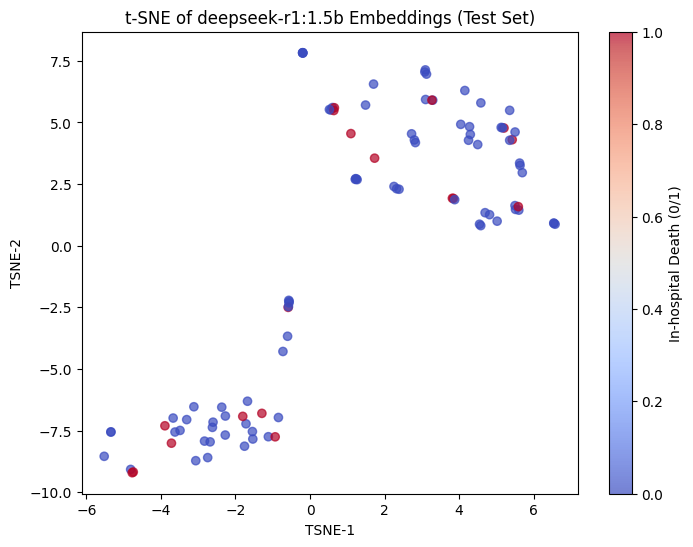

In [51]:
if run_efficient:
    train_X, train_y = build_embeddings(summaries_a_small, summary_col="summary_trend", model_name=llm_model)
    test_X, test_y = build_embeddings(summaries_b_small, summary_col="summary_trend", model_name=llm_model)
else: 
    train_X, train_y = build_embeddings(summaries_a, summary_col="summary_trend", model_name=llm_model)
    test_X, test_y = build_embeddings(summaries_b, summary_col="summary_trend", model_name=llm_model)

probs, auroc, auprc = train_and_evaluate(train_X, train_y, test_X, test_y)
print(f"Test AuROC: {auroc:.4f}, Test AuPRC: {auprc:.4f}")


if run_efficient:
    visualize_tsne(train_X, train_y, title=f"t-SNE of {llm_model} Embeddings (Test Set)")
else: 
    visualize_tsne(test_X, test_y, title=f"t-SNE of {llm_model} Embeddings (Test Set)")


# Q4.3 Using time-series foundation models

Generate small datasets for testing

In [55]:
np.random.seed(1)

a_ids_small = np.random.choice(df_a['RecordID'].unique(), size=100, replace=False)
df_a_small = df_a[df_a['RecordID'].isin(a_ids_small)]

b_ids_small = np.random.choice(df_b['RecordID'].unique(), size=10, replace=False)
df_b_small = df_b[df_b['RecordID'].isin(b_ids_small)]

In [97]:

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map=device_map,
    torch_dtype=torch.float32,
)

def get_univariate_embedding(pipeline, single_var_series):
    """
    Given a single univariate time series (1D array), return its Chronos embedding.
    """
    if not isinstance(single_var_series, torch.Tensor):
        series_tensor = torch.tensor(single_var_series, dtype=torch.float32)
    else:
        series_tensor = single_var_series.float()
    # Chronos supports single 1D tensors directly
    with torch.no_grad():
        embedding, _ = pipeline.embed(series_tensor)
        
    if embedding.ndim == 3: # bc of batch logic it returns embedding as torch.Size([1, 49, 512]) 
        embedding = embedding.squeeze(0)
    return embedding.mean(dim=0) # Average pooling

def compute_patient_embedding_naive(pipeline, multivar_data, variables):
    """
    Given a dictionary of { variable_name: 1D time series } for a patient,
    compute the average embedding across variables.
    """
    embeddings = []

    for var_name, series in multivar_data.items():
        if var_name in variables:
            if len(series) == 0:
                continue
            emb = get_univariate_embedding(pipeline, series)
            embeddings.append(emb)

    if not embeddings:
        return torch.zeros(512)  # or whatever the embedding dim is

    return torch.stack(embeddings, dim=0).mean(dim=0)  # shape: [embedding_dim]

def build_patient_embeddings_naive(pipeline, df_timeseries, df_labels, variables):
    """
    Builds Chronos embeddings per patient using naive variable-wise averaging.

    Args:
        pipeline: ChronosPipeline instance
        df_timeseries: long-form time series DataFrame with columns:
                       ['RecordID', 'Time', var1, var2, ...]
        df_labels: DataFrame with columns ['RecordID', 'In-hospital_death']
        variables: list of variable names to embed (e.g., ['HeartRate', 'WBC'])

    Returns:
        X: numpy array of shape [num_patients, embedding_dim]
        y: numpy array of shape [num_patients]
    """
    X_list = []
    y_list = []

    for rid, group in df_timeseries.groupby("RecordID"):
        patient_data = {}

        for var in variables:
            if var in group.columns:
                series = group[var].dropna().values
                if len(series) > 0:
                    patient_data[var] = series

        if not patient_data:
            continue  # skip if no valid data

        emb = compute_patient_embedding_naive(pipeline, patient_data, variables)
        X_list.append(emb.cpu().numpy())

        # Lookup label
        label_row = df_labels[df_labels['RecordID'] == rid]
        if not label_row.empty:
            y_list.append(label_row['In-hospital_death'].values[0])
        else:
            continue  # skip if label missing

    return np.vstack(X_list), np.array(y_list)


# 1) Single Embedding + Linear Probe
list_of_variables = ['Gender', 'Height', 'Weight', 'Age', 'Albumin',
       'Cholesterol', 'DiasABP', 'HCO3', 'HCT', 'HR', 'Mg', 'MAP', 'Na',
       'NIDiasABP', 'NIMAP', 'NISysABP', 'SysABP', 'PaCO2', 'PaO2',
       'Platelets', 'RespRate', 'Temp', 'ALP', 'ALT', 'AST', 'BUN',
       'Bilirubin', 'Creatinine', 'FiO2', 'GCS', 'Glucose', 'K', 'Lactate',
       'MechVent', 'Urine', 'WBC', 'pH', 'SaO2', 'TroponinT', 'TroponinI']

In [85]:
if run_efficient:
    train_X, train_y = build_patient_embeddings_naive(pipeline, df_a_small, death_a,list_of_variables)
    test_X, test_y = build_patient_embeddings_naive(pipeline, df_b_small, death_b, list_of_variables)
else: 
    train_X, train_y = build_patient_embeddings_naive(pipeline, df_a, death_a,list_of_variables)
    test_X, test_y = build_patient_embeddings_naive(pipeline, df_b, death_b, list_of_variables)

clf = LogisticRegression(max_iter=2000)
clf.fit(train_X, train_y)
probs = clf.predict_proba(test_X)[:,1]
auroc = roc_auc_score(test_y, probs)
auprc = average_precision_score(test_y, probs)
print(f"[Naive Aggregation] AuROC={auroc:.4f}, AuPRC={auprc:.4f}")

[Naive Aggregation] AuROC=0.2222, AuPRC=0.1250


Test the embedding function

In [87]:
first_id = df_a['RecordID'].unique()[0]
patient_df = df_a[df_a['RecordID'] == first_id]
multivar_data = {
    var: patient_df[var].dropna().values
    for var in list_of_variables
    if var in patient_df.columns
}

embedding = compute_patient_embedding_naive(pipeline, multivar_data, list_of_variables)
embedding

tensor([ 6.2863e-03, -6.9359e-03, -1.1306e-02, -6.0960e-05,  1.2464e-03,
         1.7797e-02,  3.4016e-03, -1.7304e-04,  8.7110e-03,  1.1644e-02,
        -1.1688e-02,  3.5049e-04,  5.0930e-03,  2.4649e-02, -3.0244e-03,
         2.8006e-02, -1.0064e-03, -1.7505e-03, -1.3899e-02, -6.2786e-03,
         1.1795e-03, -1.6851e-03,  2.1044e-03, -2.4664e-04, -2.4498e-03,
        -1.7912e-02,  6.8167e-03, -8.9116e-03, -1.4047e-02,  9.1582e-03,
         4.4931e-03, -2.6757e-03, -3.4390e-03, -9.6843e-04,  7.9745e-03,
         1.8741e-02,  1.1068e-02, -6.8100e-03,  7.0846e-03, -3.6803e-03,
         3.5000e-03, -1.2460e-03,  2.1949e-02, -2.1702e-03,  9.5594e-03,
         3.3947e-03,  2.1018e-02,  1.6352e-02,  9.4031e-03,  1.6454e-03,
         6.6717e-03, -6.2046e-03,  1.6296e-02, -2.0432e-03,  1.3001e-03,
         7.6089e-04, -2.1397e-02, -4.6681e-03,  1.2023e-02, -5.3628e-04,
         2.4141e-02, -2.3383e-02, -1.2237e-03,  1.6337e-02, -4.8070e-04,
         1.3316e-02,  5.6230e-03,  4.0628e-03, -5.6

Making a smarter aggregation: 
Instead of simply averaging embeddings across variables, we can:

Compute an embedding for each variable.

Feed all variable embeddings into a small MLP that outputs a patient-level embedding.

Then, either attach a logistic head for classification or just produce a final embedding for a standard logistic regression.

In [98]:

########################################
# 2) Simple Neural Aggregator Approach #
########################################

class ChannelAggregator(nn.Module):
    def __init__(self,num_vars, embed_dim=512, hidden_dim=64, out_dim=1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(embed_dim * num_vars, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    
    def forward(self, x):
        return self.mlp(x)

def build_multivar_embeddings(pipeline, patient_df, variables):
    """
    Takes a single patient’s time series (dataframe) and computes a stacked tensor of embeddings.
    Returns: torch.Tensor of shape [num_vars, embed_dim]
    """
    embeddings = []
    for var in variables:
        if var in patient_df.columns:
            series = patient_df[var].dropna().values
            if len(series) == 0:
                continue
            with torch.no_grad():
                emb, _ = pipeline.embed(torch.tensor(series, dtype=torch.float32))
                if emb.ndim == 3:
                    emb = emb.squeeze(0)
                emb = emb.mean(dim=0)  # [D]
                embeddings.append(emb.unsqueeze(0))  # [1, D]

    if not embeddings:
        return torch.zeros((1, 512))  # fallback for no valid data
    return torch.cat(embeddings, dim=0)  # [num_vars, D]


def train_aggregator_from_raw(pipeline, aggregator, df_timeseries, df_labels, variables, epochs=5, lr=1e-3, device='cpu'):
    aggregator.to(device)
    optimizer = torch.optim.Adam(aggregator.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    X_list, y_list = [], []
    for rid, group in df_timeseries.groupby("RecordID"):
        emb_stack = build_multivar_embeddings(pipeline, group, variables)
        if emb_stack.shape[0] < 1:
            continue  # skip patients with no valid data

        label_row = df_labels[df_labels["RecordID"] == rid]
        if label_row.empty:
            continue
        label = label_row["In-hospital_death"].values[0]

        X_list.append(emb_stack.unsqueeze(0))  # [1, num_vars, D]
        y_list.append(label)

    X_tensor = torch.cat(X_list, dim=0).float().to(device)  # [batch, num_vars, D]
    y_tensor = torch.tensor(y_list, dtype=torch.float32).unsqueeze(-1).to(device)  # [batch, 1]

    for epoch in range(epochs):
        aggregator.train()
        optimizer.zero_grad()
        logits = aggregator(X_tensor)
        loss = criterion(logits, y_tensor)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss={loss.item():.4f}")

    return aggregator


def evaluate_aggregator_from_raw(pipeline, aggregator, df_timeseries, df_labels, variables, device='cpu'):
    aggregator.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for rid, group in df_timeseries.groupby("RecordID"):
            emb_stack = build_multivar_embeddings(pipeline, group, variables)
            if emb_stack.shape[0] < 1:
                continue

            label_row = df_labels[df_labels["RecordID"] == rid]
            if label_row.empty:
                continue
            label = label_row["In-hospital_death"].values[0]

            logit = aggregator(emb_stack.unsqueeze(0).to(device))  # [1, 1]
            all_logits.append(logit.item())
            all_labels.append(label)

    all_logits = np.array(all_logits)
    all_labels = np.array(all_labels)
    probs = 1 / (1 + np.exp(-all_logits))

    auroc = roc_auc_score(all_labels, probs)
    auprc = average_precision_score(all_labels, probs)
    return auroc, auprc

In [99]:
# Create model
aggregator = ChannelAggregator(num_vars=len(list_of_variables) , embed_dim=512, hidden_dim=64, out_dim=1)

# Train
aggregator = train_aggregator_from_raw(
    pipeline=pipeline,
    aggregator=aggregator,
    df_timeseries=df_a_small if run_efficient else df_a,
    df_labels=death_a,
    variables=list_of_variables,
    epochs=5,
    lr=1e-3,
    device=device_map
)

# Evaluate
auroc, auprc = evaluate_aggregator_from_raw(
    pipeline=pipeline,
    aggregator=aggregator,
    df_timeseries=df_b_small if run_efficient else df_b,
    df_labels=death_b,
    variables=list_of_variables,
    device=device_map
)

print(f"[Neural Aggregator] AuROC={auroc:.4f}, AuPRC={auprc:.4f}")


Epoch 1/5, Loss=0.7198
Epoch 2/5, Loss=0.5807
Epoch 3/5, Loss=0.5012
Epoch 4/5, Loss=0.4697
Epoch 5/5, Loss=0.4700
[Neural Aggregator] AuROC=0.1111, AuPRC=0.1111
